In [16]:
from  netCDF4 import Dataset
import  numpy as np
import joblib
import matplotlib.pyplot as plt

In [17]:
### Load in the training data from nc files. 
def nc_load(dir = "/home/jamie/cruise_processing/falkortoo/FKt240817/wh300/wh300.nc"):
    ### Load in the test data u and v for plotting. 
    file_id = Dataset(dir)
    pg = file_id.variables["pg"][:]
    amp = file_id.variables["amp"][:]
    mask = file_id.variables["pflag"][:]
    depth = file_id.variables["depth"][:]
    # u = file_id.variables["u"][:]
    # v = file_id.variables["v"][:]
    file_id.close()

    features = np.stack([amp.flatten(), depth.flatten(), pg.flatten()], axis=1) # depth.flatten()
    predictor =  mask.flatten()
    # error velocity sounds nice too
    return(features, predictor)


In [18]:
# load the model
model = joblib.load('/home/jamie/projects/flag_model/logit_model.pkl')

### Load in the test data u for plotting. 
file_id = Dataset('/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/contour/wh300.nc')
u = file_id.variables["u"][:]
file_id.close()
s = u.shape

# laod test data for the model.
features_test, predictor_test = nc_load(dir = "/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/contour/wh300.nc")
new_y_pred = model.predict(features_test) 
# put humpoty dumpty back together again
pred_flags = new_y_pred.reshape(s[0], s[1]) 
predictor_test = predictor_test.reshape(s[0], s[1]) 
# predictor_test[predictor_test != 0] = 1

In [19]:
# Everything that isnt unflagged or manually flagged is now identified. 
auto_flagged = predictor_test.copy()
bin_flag = predictor_test.copy()

# subset only the algorithm falgs
arg = [0, 1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
auto_flagged[~idx] = 1
auto_flagged[idx] = 0

# subset only the manualy edited falgs
arg = [1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
bin_flag[~idx] = 0

# subset only the all the flags. 
all_flag = predictor_test.copy()
all_flag[all_flag != 0] = 1

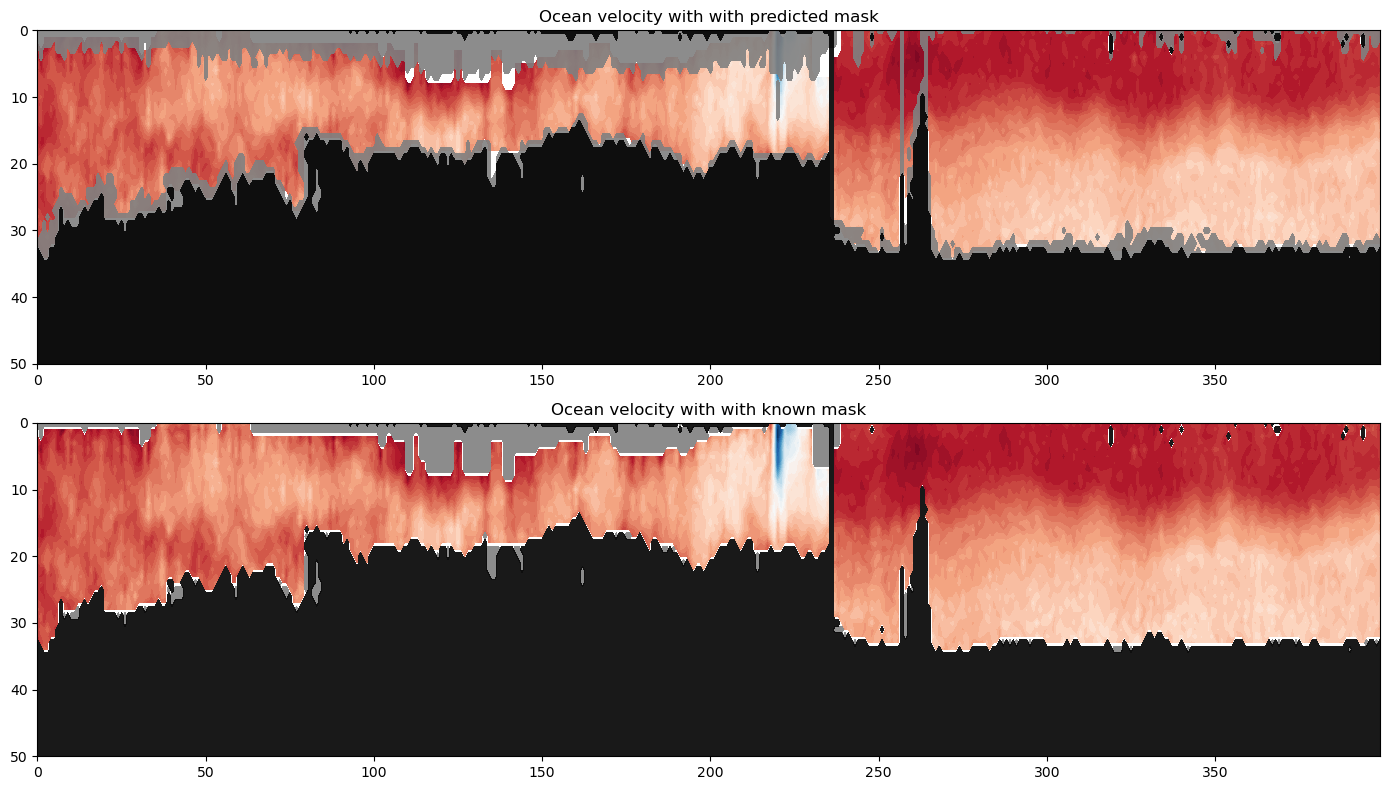

In [21]:
idx = range(4000, 4400)

# Define the feature array and predicted mask array
feature = u # n by m array
predicted_mask = pred_flags  # n by m array

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
contour1 = ax[0].contourf(feature.T[:, idx], cmap='RdBu', levels=50)
# contour1.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[0].contourf(predicted_mask.T[:, idx], levels=[0.5, 1], colors='grey', alpha=0.9)
ax[0].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.9)
ax[0].set_title('Ocean velocity with with predicted mask')
ax[0].set_ylim(50, 0)

contour2 = ax[1].contourf(feature.T[:, idx], cmap='RdBu',levels=50)
# contour2.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[1].contourf(bin_flag.T[:, idx], levels=[0.5, 1], colors='grey', alpha=0.9)
ax[1].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.9)
ax[1].set_title('Ocean velocity with with known mask')
ax[1].set_ylim(50, 0)
# fig.colorbar(contour2, ax=ax, orientation='vertical', label="ocean velocity")
plt.tight_layout()
plt.show()